# **Final project** 
### **CheckMySkin - Skin lesion control**
by : Kamlesh Seeruttun, Valentin Lewandowski, Charlotte Villet, Ghizlane Daoudi & Pierre-Alexandre Chanteau

### **Mounting Google drive on Colab**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Importing useful librairies**

In [ ]:
import tensorflow as tf 
import numpy as np
import pandas as pd
import datetime, os
%load_ext tensorboard

### **Defining different working paths to access data and store results**

In [ ]:
path_csv = "/content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/SRC/HAM10000_metadata.csv"
path_to_file_img = "/content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/SRC/src_img/"
path_savemodel = "/content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/GHD/model_GHD4.h5"
checkpoint_path = "/content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/GHD/model_GHD4/cp-{epoch:04d}.ckpt"

### **Downloading the dataset and looking at the first five rows**

### **Basic statistics of the dataset**

In [ ]:
data_base = pd.read_csv(path_csv)
data_base = data_base.sample(frac=1,random_state=0).reset_index(drop=True)
data_base.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0002695,ISIC_0028664,nv,follow_up,45.0,male,back
1,HAM_0000370,ISIC_0025998,nv,follow_up,70.0,male,trunk
2,HAM_0006372,ISIC_0032817,nv,histo,35.0,male,back
3,HAM_0006835,ISIC_0026577,nv,histo,75.0,male,chest
4,HAM_0005536,ISIC_0026798,bcc,histo,45.0,male,lower extremity


In [ ]:
data_base.shape

(10015, 7)

### **Creating new column "lesion_type" for better readability**

In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

data_base['lesion_type'] = data_base['dx'].map(lesion_type_dict.get) 

data_base = data_base.drop(columns=["dx"])

data_base.head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type
0,HAM_0002695,ISIC_0028664,follow_up,45.0,male,back,Melanocytic nevi
1,HAM_0000370,ISIC_0025998,follow_up,70.0,male,trunk,Melanocytic nevi
2,HAM_0006372,ISIC_0032817,histo,35.0,male,back,Melanocytic nevi
3,HAM_0006835,ISIC_0026577,histo,75.0,male,chest,Melanocytic nevi
4,HAM_0005536,ISIC_0026798,histo,45.0,male,lower extremity,Basal cell carcinoma


### **Creating new column "severity" to classify the lesion types in three distinct groups**

In [ ]:
# Creating new column of severity

severity_dict = {
    'Melanocytic nevi': "Don't worry, it's benign",
    'Melanoma': "Detection of a potential severity, please consult a doctor",
    'Benign keratosis-like lesions': "Don't worry, it's benign",
    'Basal cell carcinoma': "Detection of a potential severity, please consult a doctor",
    'Actinic keratosis': 'To monitor',
    'Vascular lesions': 'To monitor',
    'Dermatofibroma': "Don't worry, it's benign"
}

data_base['severity'] = data_base['lesion_type'].map(severity_dict.get) 

data_base.head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,severity
0,HAM_0002695,ISIC_0028664,follow_up,45.0,male,back,Melanocytic nevi,"Don't worry, it's benign"
1,HAM_0000370,ISIC_0025998,follow_up,70.0,male,trunk,Melanocytic nevi,"Don't worry, it's benign"
2,HAM_0006372,ISIC_0032817,histo,35.0,male,back,Melanocytic nevi,"Don't worry, it's benign"
3,HAM_0006835,ISIC_0026577,histo,75.0,male,chest,Melanocytic nevi,"Don't worry, it's benign"
4,HAM_0005536,ISIC_0026798,histo,45.0,male,lower extremity,Basal cell carcinoma,"Detection of a potential severity, please cons..."


### **Creating new column "localization2" where the four possible values are face, upper part, lower part and unknown**

In [ ]:
data_base["localization2"]= data_base['localization'].apply(lambda x : 
                             'face' if x=='face'
                            else 'upper_part' if x=='trunk'or x=='upper extremity' or x=='abdomen' or x=='neck' or x=='scalp' or x=='hand' or x=='ear'
                            else 'lower_part' if x=='back' or x=='lower extremity' or x=='chest' or x=='foot' or x=='genital' or x=='acral'
                            else 'unknown')

### **Overview of a sample of five lines of the dataset**

In [ ]:
data_base.head()

,lesion_id,image_id,dx_type,age,sex,localization,lesion_type,severity,localization2
0,HAM_0002695,ISIC_0028664,follow_up,45.0,male,back,Melanocytic nevi,"Don't worry, it's benign",lower_part
1,HAM_0000370,ISIC_0025998,follow_up,70.0,male,trunk,Melanocytic nevi,"Don't worry, it's benign",upper_part
2,HAM_0006372,ISIC_0032817,histo,35.0,male,back,Melanocytic nevi,"Don't worry, it's benign",lower_part
3,HAM_0006835,ISIC_0026577,histo,75.0,male,chest,Melanocytic nevi,"Don't worry, it's benign",lower_part
4,HAM_0005536,ISIC_0026798,histo,45.0,male,lower extremity,Basal cell carcinoma,"Detection of a potential severity, please cons...",lower_part


### **Creating a new dataset with relevant columns and filling missing values in age column with the median**

In [ ]:
data=pd.DataFrame()
data["image_id"] = data_base["image_id"].astype("str") + ".jpg"
data["age"]=data_base["age"]
data.loc[:,'age'] = data['age'].fillna(data['age'].median())
data["sex"] = data_base["sex"]
data["localization"] = data_base["localization"]
data["severity"]=data_base['severity']
# data.describe(include="all")

### **Overview of a sample of five lines of the new dataset**

In [ ]:
data.head()

,image_id,age,sex,localization,severity
0,ISIC_0028664.jpg,45.0,male,back,"Don't worry, it's benign"
1,ISIC_0025998.jpg,70.0,male,trunk,"Don't worry, it's benign"
2,ISIC_0032817.jpg,35.0,male,back,"Don't worry, it's benign"
3,ISIC_0026577.jpg,75.0,male,chest,"Don't worry, it's benign"
4,ISIC_0026798.jpg,45.0,male,lower extremity,"Detection of a potential severity, please cons..."


### **Create a sample of 100 rows to speed up the execution (used to make sure that the algorithm is running)**

In [ ]:
data = data.sample(100).reset_index()

### **Seperating the features from the target**

In [ ]:
# Defining variables for the model
image_name = 'image_id'
target_name = 'severity'
features_names = ['age','sex','localization']

img = data.loc[:,image_name]

# Separating images for tabular data and target to preprocess conveniently each one 
## Selecting tabular features for one-hot encoding
X = data.loc[:,[c for c in features_names]]

## Creating a series with paths to images. This will be used later to upload images
path_to_im = [(str(path_to_file_img)+str(img[i])) for i in range(data.shape[0])]

# Defining target for label-encoding
Y = data.loc[:,target_name]

### **One-hot encoding features and label-encoding the target and importing different tools for further processing**

In [ ]:
# Preprocess the tabular features (all categorical) and the target

## Importing OneHotEncoder and LabelEncoder modules from sklearn
from sklearn.preprocessing import  OneHotEncoder, LabelEncoder

## One-hot encoding tabular features
OHE = OneHotEncoder(sparse=False)
X = OHE.fit_transform(X) 

## Label-encoding the target
le = LabelEncoder()
Y = le.fit_transform(Y)

### **Storing the one-hot encoding in a joblib for future use while interpreting data input by users in the web app**

In [ ]:
import joblib 

joblib.dump(OHE, 'encoder.joblib')

['encoder.joblib']

### **Listing feature categories and target classes**

In [ ]:
import itertools

col_X=list(itertools.chain.from_iterable(OHE.categories_))
col_Y=list(le.classes_)

### **Tests to see if one-hot encoding and label-encoding are working as expected**

In [ ]:
# Lenth of the array of the one-hot encoding
len(col_X)

36

In [ ]:
# Lenth of the array of the label encoding
col_Y

['Detection of a potential severity, please consult a doctor',
 "Don't worry, it's benign",
 'To monitor']

### **Verifying the correspondence between the initial classes and the encoded ones**

In [ ]:
le.transform(['Detection of a potential severity, please consult a doctor',
 "Don't worry, it's benign",
 'To monitor'])

array([0, 1, 2])

### **Test to make sure that the joblib encodes correctly the tabular inputs in the app**

In [ ]:
input_test={'age': 30,'sex': 'male','localization': 'face'}
X_test = pd.DataFrame(input_test, index=[0])
X_test
OHE.transform(X_test)

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

### **Defining image size and channels of the images for the model**

In [ ]:
IMG_SIZE = 256
CHANNELS = 3

### **Defining a function to load and process images: this function takes the path where the image is stored as input and returns a tensor of the image decoded and resized**

In [ ]:
def load_and_process_image(path_image) :
  img_size=IMG_SIZE
  im_bytes = tf.io.read_file(path_image)
  image_dec = tf.image.decode_jpeg(im_bytes, name="tensor_image", channels=CHANNELS)
  im = tf.image.resize(image_dec,(img_size,img_size))
  
  return(im)

### **Creating arrays with tensors for tabular data, path to images and target**

In [ ]:
# Tabular features and target
tabular = [(tf.reshape(tf.convert_to_tensor(X[i,:], name="tensor_cat_features"),[1,-1])) for i in range(data.shape[0])]
target = [(tf.constant(Y[i],name="tensor_target")) for i in range(data.shape[0])]

# Images
#image = [load_and_process_image("/content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/SRC/src_img/{}".format(img[i]))for i in range(data.shape[0])]
# The following method to store the decoded images didn't work for 10k images on Google Colab. It required too much memory ressources. That's the reason why we chose to use the "".map" method
path_to_im_tensor = [(tf.constant(path_to_im[i],name="tensor_path_to_image")) for i in range(data.shape[0])]

### **Creating a TensorSliceDataset from the array with path_to_im_tensor for use with the ".map" method**

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(path_to_im_tensor)

### **Creating a TensorSlice dataset for tabular features, images and the target respectively**

In [ ]:
image = ds.map(load_and_process_image)
tabular = tf.data.Dataset.from_tensor_slices(tabular)
target = tf.data.Dataset.from_tensor_slices(target)

### **Verifying the shape of the tabular input**

In [ ]:
tabular

<TensorSliceDataset shapes: (1, 36), types: tf.float64>

### **Bringing together in a single dataset the image file, the tabular data and the target**

In [ ]:
# Zipping the three TensorSlice datasets into a tuple.
# The first element of this tuple will contain a dictionnary with the image and the tabular features while the second one will contain the associated target
df = tf.data.Dataset.zip(({"input_image": image, "input_tabular": tabular}, target))

### **Splitting the data into train, validation and test sets**

In [ ]:
# Defining the dataset size and the batch size that will be used to train the model
DATASET_SIZE = data.shape[0]
BATCH_SIZE = 200

# Defining proportions of data that will be used in the train set, the validation set and the test set
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

# Shuffling the dataset using a seed to make sure that it will behave the same way for all the team members 
# In the initial dataset the targets are not well shuffled. The methods .take() and .skip()) used below take data in the order they are. We will therefore shuffle our data first.
full_dataset = df.shuffle(buffer_size=DATASET_SIZE, seed=123)

# Defining train, val and test sets using the proportions defined above
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size).take(test_size)
val_dataset = full_dataset.skip(train_size + test_size)

# Shuffling and batching the datasets
train = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True).batch(BATCH_SIZE)
val = val_dataset.shuffle(buffer_size=val_size,reshuffle_each_iteration=True).batch(BATCH_SIZE)
test = test_dataset.batch(BATCH_SIZE)

### **Defining the different layers of the deep learning model**

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

# Define shapes for model inputs and target
img_data_shape = (IMG_SIZE, IMG_SIZE, CHANNELS)
csv_data_shape = (1,X.shape[1])
num_classes = len(data['severity'].unique())


# Defining an architecture with two branches
# Defining the two input channels : image and tabular data
img_input = tf.keras.layers.Input(shape=img_data_shape, name="input_image")
csv_input = tf.keras.layers.Input(shape=csv_data_shape, name="input_tabular")

# Defining layers for image data 
x1 = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(img_input)
x1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = "same", activation = "relu", name="conv1_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp1_img")(x1)
x1 = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = "same", activation = "relu", name="conv2_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp2_img")(x1)
x1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3,3), strides = 1, padding = "same", activation = "relu", name="conv3_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp3_img")(x1)
x1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (2,2), strides = 1, padding = "same", activation = "relu", name="conv4_img")(x1)
x1 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (2,2), strides = 1, padding = "same", activation = "relu", name="conv5_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp4_img")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_img")(x1)

# Defining layers for tabular data
#x2 = tf.keras.layers.Flatten(name="flatten_csv")(csv_input)
x2 = tf.keras.layers.Dense(len(col_X), activation='relu', name="dense1_csv")(csv_input)
x2 = tf.keras.layers.Dense(8, activation='relu', name="dense3_csv")(x2)
x2 = tf.keras.layers.Flatten(name="flatten_csv")(x2)

# Merging layers
x = tf.keras.layers.concatenate([x1,x2], name="concat_csv_img")
x = tf.keras.layers.Dense(32, activation='relu', name="dense1_csv_img")(x)
x = tf.keras.layers.Dense(16, activation='relu', name="dense2_csv_img")(x)
output = tf.keras.layers.Dense(num_classes, activation="softmax", name="classify")(x)

# Building the model with two branches: two inputs and one output
model = tf.keras.models.Model(inputs=[img_input, csv_input], outputs=output)

### **Looking at the structure of the model created above**

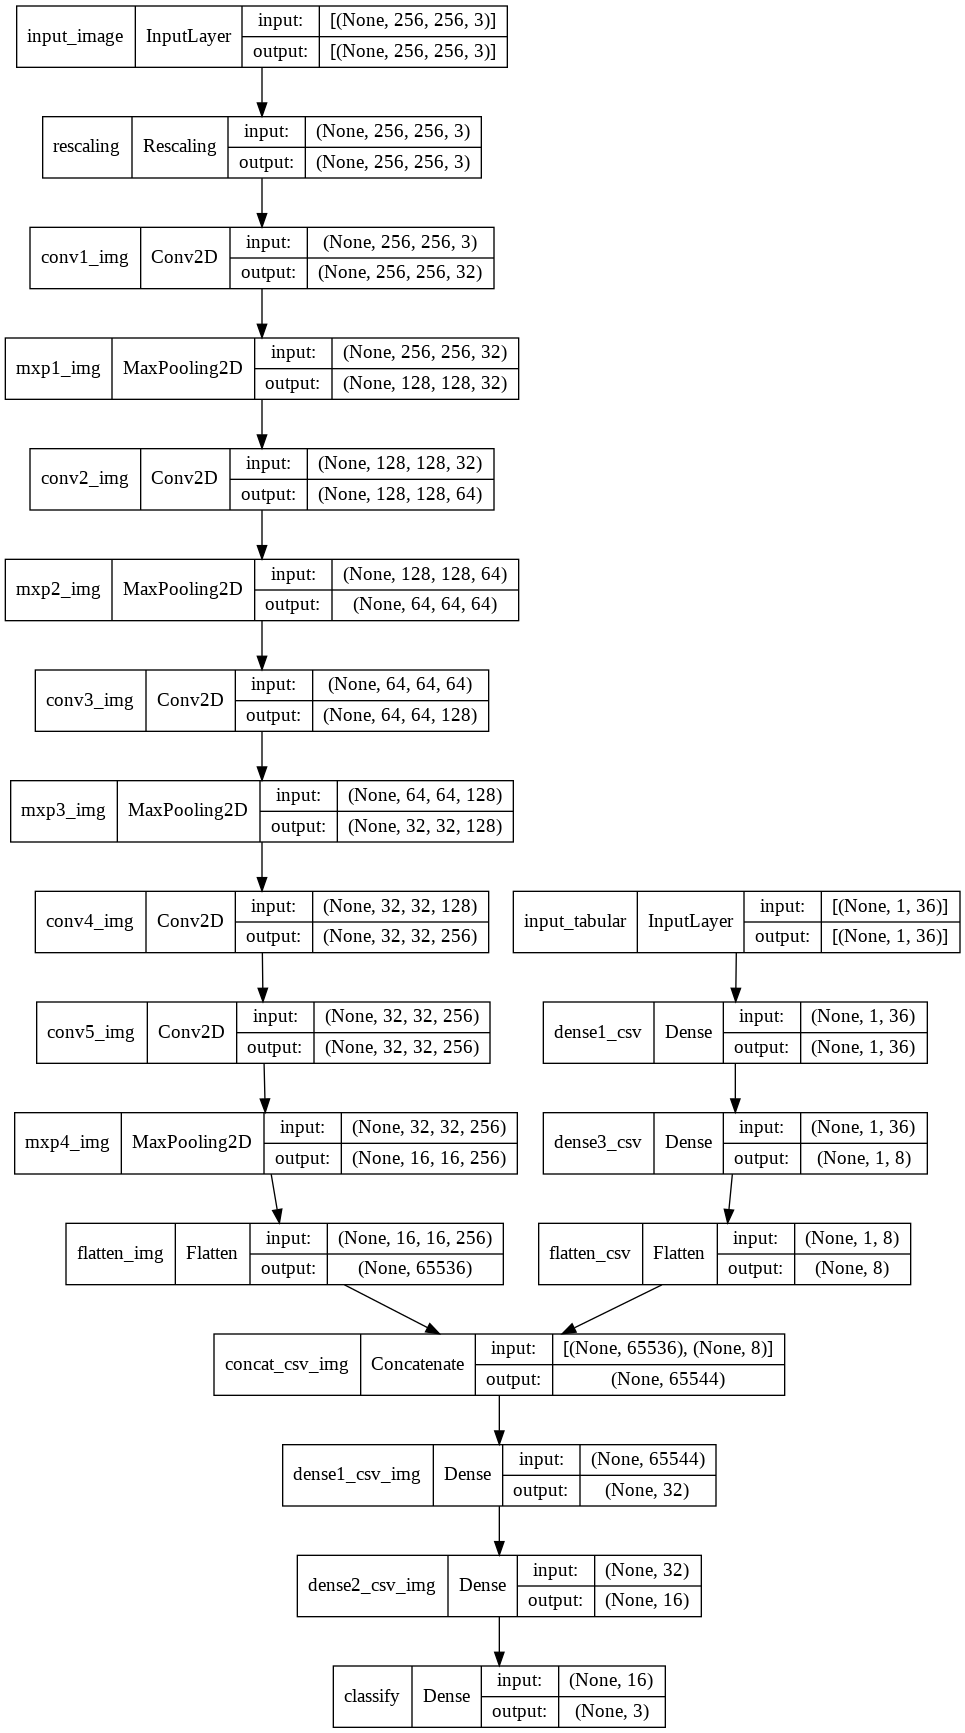

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### **Compiling the model with the relevant optimizer, loss and metrics**

In [ ]:
# Importing losses, metrics and optimizers that will be used

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Recall
from tensorflow.keras.optimizers import Adam

# Compiling the model
model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [ ]:
# Defining tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

### **# Defining and saving the chekpoints at the end of each epoch**

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=True,
    save_freq=1*len(train))
model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
steps_per_epoch = train_size/BATCH_SIZE
steps_per_epoch

35.05

### **Training the model**

In [ ]:
history = model.fit(train, epochs=50, validation_data=val, callbacks=[tensorboard_callback,cp_callback])

Epoch 1/50
35/36 [============================>.] - ETA: 0s - loss: 0.6657 - sparse_categorical_accuracy: 0.7680
Epoch 00001: saving model to /content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/GHD/model_GHD4/cp-0001.ckpt
36/36 [==============================] - 79s 1s/step - loss: 0.6655 - sparse_categorical_accuracy: 0.7680 - val_loss: 0.5768 - val_sparse_categorical_accuracy: 0.7984
Epoch 2/50
35/36 [============================>.] - ETA: 0s - loss: 0.5818 - sparse_categorical_accuracy: 0.7923
Epoch 00002: saving model to /content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/GHD/model_GHD4/cp-0002.ckpt
36/36 [==============================] - 64s 1s/step - loss: 0.5816 - sparse_categorical_accuracy: 0.7924 - val_loss: 0.5566 - val_sparse_categorical_accuracy: 0.8051
Epoch 3/50
35/36 [============================>.] - ETA: 0s - loss: 0.5564 - sparse_categorical_accuracy: 0.7914
Epoch 00003: saving model to /content/drive/MyDrive/### Students ###/# Projects #/# BDMP 

In [ ]:
#history.history

### **Displaying tensorboard**

In [ ]:
%tensorboard --logdir logs

### **Loading weights at a specific epoch (this can prove to be useful if we overfit and we want to go back to a previous epoch)**

In [ ]:
#model.load_weights("/content/drive/MyDrive/### Students ###/# Projects #/# BDMP #/GHD/model_GHD1bis/cp-0025.ckpt")

### **Loading the best model from the path it was saved**

In [ ]:
model = tf.keras.models.load_model(path_savemodel)

### **Evaluating the model's performance on the test set**

In [ ]:
model.evaluate(test)

8/8 [==============================] - 31s 340ms/step - loss: 0.0952 - sparse_categorical_accuracy: 0.9654


[0.09524919092655182, 0.9653794765472412]

In [ ]:
#model.evaluate(test)

8/8 [==============================] - 29s 332ms/step - loss: 0.0903 - sparse_categorical_accuracy: 0.9647


[0.090309277176857, 0.9647136926651001]

In [ ]:
#model.save(path_savemodel)

### **Conducting tests to see if the model is responding well to the  different inputs**

In [ ]:
# To plot the confusion matrix, the real target has to be compared to the prediction for each row 
# To do so, the test inputs are stored in an array and the target is stored in another one. Thus, way we make sure that the two arrays are in the same order
test_target = []
test_inputs = []

for i, j in test_dataset.as_numpy_iterator():
  test_inputs.append(i)
  test_target.append(j)

### **The test input is a dictionnary where are stored the "input_image" and the "input_tabular"**

In [ ]:
(test_inputs[0]['input_image']).shape

(256, 256, 3)

In [ ]:
test_inputs[0]['input_image']

array([[[227.28973, 154.5827 , 177.61719],
        [226.     , 157.84387, 177.54688],
        [228.61273, 158.23328, 180.30243],
        ...,
        [231.69928, 160.98047, 183.86499],
        [232.9671 , 162.4768 , 186.08606],
        [229.94006, 158.99408, 183.23358]],

       [[227.4961 , 155.83405, 178.90045],
        [226.14166, 155.9123 , 179.64166],
        [225.9184 , 159.46545, 181.93854],
        ...,
        [233.34723, 162.53021, 187.95886],
        [231.87463, 158.88104, 187.60974],
        [228.12689, 155.5567 , 184.96283]],

       [[227.43689, 154.67352, 177.9397 ],
        [228.7685 , 156.82361, 178.77344],
        [226.35852, 157.28314, 179.99408],
        ...,
        [226.39221, 158.99408, 182.66986],
        [229.18134, 158.86987, 184.97699],
        [229.21094, 154.90344, 184.1518 ]],

       ...,

       [[217.98663, 152.60101, 156.52686],
        [216.88055, 156.67291, 158.7315 ],
        [215.99176, 156.3977 , 156.1383 ],
        ...,
        [215.75665, 159.39

### **Testing on the first row to adjust shapes for the predictions**

In [ ]:
# 1,1 has been added for each shape:
#        - The first 1 was added to make sure that the tensor slice will not slice the image itself (The from tensor slices method by construction slices over the first dimansion)
#        - The second 1 was added because we will take each time 1 element to make a prediction on it
test_tensor_input_0 = {"input_image": tf.constant(test_inputs[0]['input_image'], shape=(1,1,256,256,3)), "input_tabular": tf.constant(test_inputs[0]['input_tabular'], shape = (1,1,1,36))}

In [ ]:
a = tf.data.Dataset.from_tensor_slices(test_tensor_input_0)

### **Prediction for the first row of the test set: an array with 3 values**

In [ ]:
model.predict(a)

array([[1.599233e-08, 1.000000e+00, 9.409935e-11]], dtype=float32)

### **Extracting prediction that corresponds to the highest value of the prediction array**

In [ ]:
tf.argmax(prediction_a, axis=1)

### **Generalizing for all rows: construct an array where will be stored the predictions row by row for the test set**

In [ ]:
test_predictions=[]

for i in range(test_size):
  test_tensor_input = {"input_image": tf.constant(test_inputs[i]['input_image'], shape=(1,1,256,256,3)), "input_tabular": tf.constant(test_inputs[i]['input_tabular'], shape = (1,1,1,36))}
  test_prediction = model.predict(tf.data.Dataset.from_tensor_slices(test_tensor_input))
  test_predictions.append(tf.argmax(test_prediction, axis=1))

 ### **Retrieving the confusion matrix with y_test true as tensor**

In [ ]:
# The test target and the test predictions follow the same order as the predictions were made row by row from the test inputs
cm = tf.math.confusion_matrix(test_target,test_predictions)

In [ ]:
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 248,   21,    0],
       [  13, 1147,    4],
       [   4,    3,   62]], dtype=int32)>

 ### **Retrieving the confusion matrix with y_test true as a numpy array**

In [ ]:
# get CM with y_test_true as nuppy array

cma = np.array(cm)
cma

array([[ 248,   21,    0],
       [  13, 1147,    4],
       [   4,    3,   62]], dtype=int32)

 ### **Checking the model's accuracy mean as compared to the above model evaluation**

In [ ]:
accuracy_mean = (cma[0][0]+cma[1][1]+cma[2][2])/cma.sum()

accuracy_1 = cma[0][0]/cma[0].sum()
accuracy_2 = cma[1][1]/cma[1].sum()
accuracy_3 = cma[2][2]/cma[2].sum()

print('accuracy on accuracy_mean is : {} '.format(accuracy_mean))

print('accuracy on accuracy_1 is : {} '.format(accuracy_1))
print('accuracy on accuracy_2 is : {} '.format(accuracy_2))
print('accuracy on accuracy_3 is : {} '.format(accuracy_3))

accuracy on accuracy_mean is : 0.9700399467376831 
accuracy on accuracy_1 is : 0.9219330855018587 
accuracy on accuracy_2 is : 0.9853951890034365 
accuracy on accuracy_3 is : 0.8985507246376812 


 ### **Sanity checks before plotting the final confusion matrix**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### **Checking labels names**

In [ ]:
col_Y

['Detection of a potential severity, please consult a doctor',
 "Don't worry, it's benign",
 'To monitor']

In [ ]:
short_col_Y = col_Y
short_col_Y[0]='dermato_check'
short_col_Y[1]='begnin'
short_col_Y[2]='self_monitor'
short_col_Y

['dermato_check', 'begnin', 'self_monitor']

Confusion matrix, without normalization
[[ 248   21    0]
 [  13 1147    4]
 [   4    3   62]]


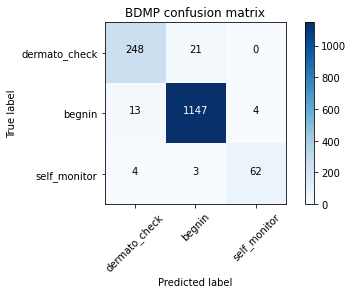

In [ ]:
plot_confusion_matrix(cm=cma,classes=short_col_Y, title='BDMP confusion matrix')

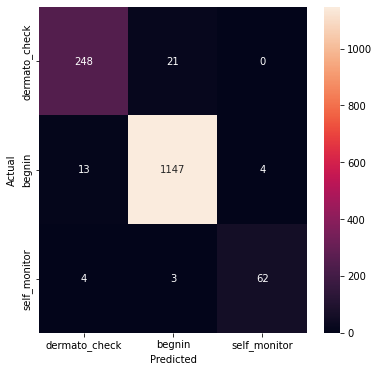

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cma, annot=True, xticklabels=short_col_Y, yticklabels=short_col_Y,fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [ ]:
248/(248+21)

0.9219330855018587

In [ ]:
cma.sum(axis=1)[:, np.newaxis]

array([[ 269],
       [1164],
       [  69]])

In [ ]:
cmn = cma.astype('float') / cma.sum(axis=1)[:, np.newaxis]

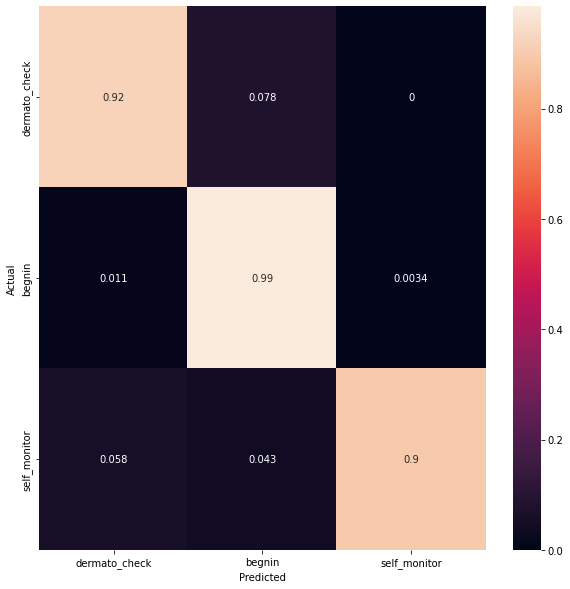

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, xticklabels=short_col_Y, yticklabels=short_col_Y)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

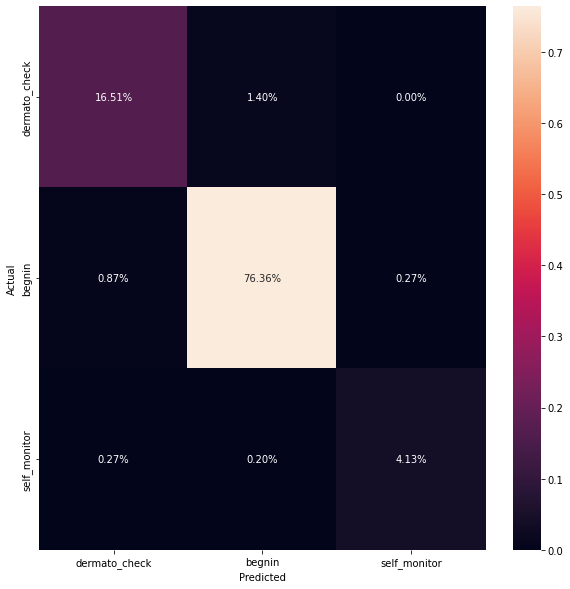

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cma/np.sum(cma), annot=True, xticklabels=short_col_Y, yticklabels=short_col_Y,fmt='.2%')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

 ### **Printing the classification report to have an overview of the model's global performance**

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_target,test_predictions, target_names=short_col_Y))

               precision    recall  f1-score   support

dermato_check       0.94      0.92      0.93       269
       begnin       0.98      0.99      0.98      1164
 self_monitor       0.94      0.90      0.92        69

     accuracy                           0.97      1502
    macro avg       0.95      0.94      0.94      1502
 weighted avg       0.97      0.97      0.97      1502



### **Precision = TP / (TP+FP)**
### **Recall = TP / (TP+FN)**
### **Accuracy = # of correct predictions / total # of predictions**
### **F1 score = 2 * (Precision * Recall) / (Precision + Recall)**

In [ ]:
accuracy on accuracy_mean is : 0.9700399467376831 
accuracy on accuracy_1 is : 0.9219330855018587 
accuracy on accuracy_2 is : 0.9853951890034365 
accuracy on accuracy_3 is : 0.8985507246376812 

In [ ]:
(0.92+0.99+0.9)/3

0.9366666666666666

In [ ]:
(0.92*269+0.99*1164+0.9*69)/(269+1164+69)

0.973328894806924